In [2]:
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.6 MB/s eta 0:00:00


In [3]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import AutoModelForSequenceClassification, AutoTokenizer, get_scheduler
from tqdm.auto import tqdm
import evaluate
import uuid

from classification import ReviewDataSet, load_and_prepare_data, train_model


In [4]:
# load data
print("loading data...\n")
path = "drive/MyDrive/yelp_reviews"
df = load_and_prepare_data(path+"/yelp_academic_dataset_review.json", sample_size=50000, COLAB=True)

loading data...

Mounted at /content/drive


In [5]:
# create dataset
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased', use_fast=False)
review_dataset = ReviewDataSet(tokenizer, df)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [6]:
# train and val split
train_size = int(0.8 * len(review_dataset))
val_size = len(review_dataset) - train_size
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = torch.utils.data.random_split(review_dataset, [train_size, val_size], generator)
print(f'train and validation dataset sizes: {len(train_dataset), len(val_dataset)}\n')

train and validation dataset sizes: (16012, 4003)



In [7]:
# dataloader
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=8)
val_dataloader = DataLoader(val_dataset, batch_size=8)

In [8]:
# initialize model
model = AutoModelForSequenceClassification.from_pretrained('bert-base-cased', num_labels=5)
optimizer = AdamW(model.parameters(), lr=5e-5)
num_params = sum([p.numel() for p in model.parameters()])
print(f"model params: {num_params}\n")

epochs = 3
train_steps = epochs * len(train_dataloader)
lr_scheduler = get_scheduler(name='linear', optimizer=optimizer, num_warmup_steps=0, num_training_steps=train_steps)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model params: 108314117



In [9]:
# set device and send model to device
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [10]:
device

device(type='cuda')

beginning model training...



  0%|          | 0/6006 [00:00<?, ?it/s]

model id :: 39856d16-3261-45ee-8446-357be29abc9a
evaluating model...



Accuracy: 0.5610791906070447
saving model at epoch: 1, step: 400
current best accuracy: 0.5610791906070447

evaluating model...

Accuracy: 0.5263552335748188
skipping model save...
current best accuracy: 0.5610791906070447

evaluating model...

Accuracy: 0.5850612040969273
saving model at epoch: 1, step: 1200
current best accuracy: 0.5850612040969273

evaluating model...

Accuracy: 0.592305770671996
saving model at epoch: 1, step: 1600
current best accuracy: 0.592305770671996

evaluating model...

Accuracy: 0.5960529602797902
saving model at epoch: 1, step: 2000
current best accuracy: 0.5960529602797902

evaluating model...

Accuracy: 0.6190357232075943
saving model at epoch: 2, step: 400
current best accuracy: 0.6190357232075943

evaluating model...

Accuracy: 0.6215338496127905
saving model at epoch: 2, step: 800
current best accuracy: 0.6215338496127905

evaluating model...

Accuracy: 0.6190357232075943
skipping model save...
current best accuracy: 0.6215338496127905

evaluating mod

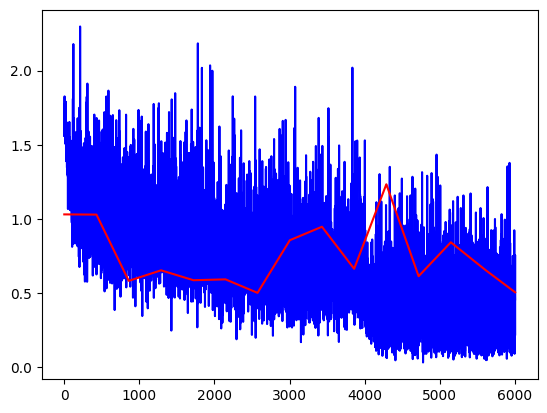

In [11]:
# train model
print("beginning model training...\n")
train_model(model, epochs, train_dataloader, val_dataloader, train_steps, optimizer, lr_scheduler, path)
print("complete")

In [ ]:
# load pretrained model
# path = "drive/MyDrive/yelp_reviews/bert_model"
path = "drive/MyDrive/yelp_reviews/outputs/bert/302656d9-aa1a-4028-94d4-3fda972caf28/epoch_2/step_1492/"

model = AutoModelForSequenceClassification.from_pretrained(path)
model.to(device)